# Surrogate Quality
This notebook produces a figure like:

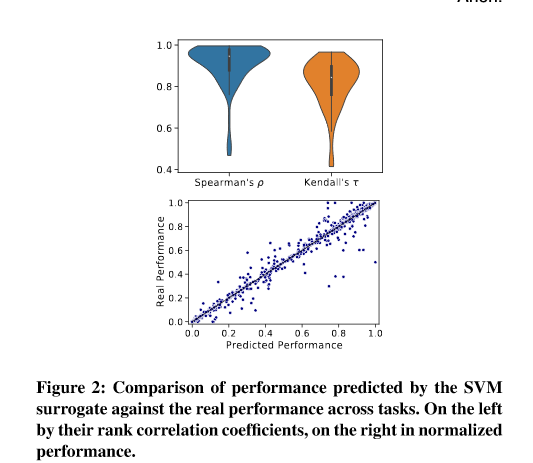

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [85]:
if "Figures" not in os.getcwd():
    os.chdir("Figures")
os.mkdir("generated/Figure2")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'generated/Figure2'

This notebook uses the data generated by the `Surrogates` notebook.

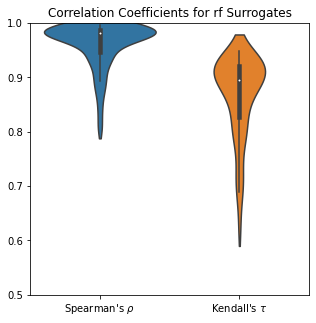

In [86]:
learner = "svm"
for learner in ["svm", "rpart", "knn", "glmnet", "xgboost", "rf"][-1:]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    surrogate_quality = pd.read_csv(f"../data/surrogate_quality/rho_{learner}.csv")
    used_surrogates = surrogate_quality[surrogate_quality.rho > 0.8]
    rank_metrics = used_surrogates[['rho', 'tau']]
    ax = sns.violinplot(data=rank_metrics, cut=1.0)
    ax.set_xticklabels([r"Spearman's $\rho$", r"Kendall's $\tau$"])
    ax.set_title(f"Correlation Coefficients for {learner} Surrogates")
    ax.set_ylim([0.5, 1.0])
    plt.savefig(f"generated/Figure2/{learner}_correlation_violin.pdf", bbox_inches='tight', pad_inches=.1)

The second plot shows, per the paper:
> For each task 10 configurations were sampled as a test set, and a surrogate model was trained on the remainder of the meta data for that task. On the right in Figure 2 the predicted normalized performance is shown against the real normalized performance.

In [87]:
import os
import sys
sys.path.append("./src/")
if "Figures" in os.getcwd():
    os.chdir("..")

In [88]:
from problem import Problem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [89]:
import itertools

for learner in ["rf"]: # ["svm", "rf", "rpart", "knn", "glmnet", "xgboost"]:
    problem = Problem(f"mlr_{learner}")
    modeled_hyperparameters = set(problem.hyperparameters) #  - set(problem.fixed)
    scores = dict()
    for task in problem.data.task_id.unique():
        task_data = problem.data[problem.data.task_id == task].copy()
        target = task_data["target"] # negated so we can maximize
        task_data["target"] = (target - min(target)) / (max(target)-min(target))

        x, y = task_data[modeled_hyperparameters], task_data["target"]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10, random_state=42)

        surrogate = RandomForestRegressor(n_estimators=100)
        surrogate.fit(x_train, y_train)
        y_pred = surrogate.predict(x_test)

        scores[task] = dict(predicted=y_pred, actual=y_test)
        
    
    predicted = itertools.chain(*(score["predicted"] for task, score in scores.items()))
    actual = itertools.chain(*(score["actual"] for task, score in scores.items()))
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    sns.scatterplot(x=predicted, y=actual, ax=ax)
    ax.set_xlabel("Predicted Normalized Logloss")
    ax.set_ylabel("Actual Normalized Logloss")
    sns.lineplot(x=[0, 1], y=[0, 1], color='red', ax=ax)
    plt.savefig(f"Figures/generated/Figure2/{learner}_predicted_v_actual.pdf", bbox_inches='tight', pad_inches=.1)

KeyboardInterrupt: 